# Calculating CO<sub>2</sub> fluxes from fixed station data

In this tutorial we'll look at how FluxEngine can be used to calculate gas fluxes using fixed station data. Fixed station data differ from other input data that you might use with FluxEngine in that you'll usually have files with a long temporal dimension and a small (single point) spatial extent. The way we've used FluxEngine in the previous tutorials has been with relatively few temporal points (or even a single point) with data spread over a large horizontal extent, and so FluxEngine reads input data for each time point from a separate file and produces a separate output file.

We could split the fixed station input data up into separate files for each time point, calculate all the fluxes individually, then merge all the output files back into a time series. However, this would require a lot of work and it would be easy to make a mistake. Instead, we'll utilise options within FluxEngine to tell it to expect input as a single file containing all time points. We will also tell FluxEngine to produce a single output file which will allow us to treat the output as a time series and make it easier to conduct further analysis. The differences are primarily in setting up the FluxEngine configuration file, but we've included the start-to-finish workflow starting with a text formatted in situ data file.

## Set the working directory
The first thing to do, as always, is to set the working directory. We will create a new directory to be our working directory and store all the files associated with this tutorial in it (the same as we've done in previous tutorials). Run the code below to do this.

By default this will create a `FluxEngineTutorials/tutorials_03` directory in your home directory. If you want to change this you can do so by modifying the line of the script starting with `workingDirectory =`. We will refer back to this directory as the tutorial's working directory so you should make a note of it.

In [ ]:
#This code changes the working directory from the tutorial folder in your FluxEngine installation
# to a newly created folder in your home drive
import os;
import matplotlib.pyplot as plt; #Used later for plotting

homeDirectory = os.path.expanduser("~");
workingDirectory = os.path.join(homeDirectory, "FluxEngineTutorials", "tutorial_03"); #Change this line to change th default location for files you create in this tutorial.

if os.path.exists(workingDirectory) == False: #If the new directory doesn't already exist, create it
    os.makedirs(workingDirectory);
os.chdir(workingDirectory);
print("Working directory is now:", os.getcwd());

## Data from Östergarnsholm station
[Östergarnsholm station](http://www.icos-sweden.se/station_ostergarnsholm.html) is a fixed station just off the coast of Östergarnsholm, East of Gotland in the Baltic Sea (situated 57.42N, 18.99E). The station, which was established in 1995 to collect data on the ocean-atmosphere boundary layer, is equipped with instruments to measure water temperature, wind speed and, amongst other things, aqueous fCO<sub>2</sub>.

We'll use data collected from this station over a 10 month period from 28th January 2015 to the 25th November 2015. These data are publicly available from [PANGAEA](https://doi.pangaea.de/10.1594/PANGAEA.878531).

In addition to sea surface temperature and aqueous fCO<sub>2</sub> that are directly measured from the station, the dataset download provides interpolated salinity from the [World Ocean Atlas (WOA) database](https://www.nodc.noaa.gov/cgi-bin/OC5/woa18/woa18.pl?parameter=s), interpolated air pressure from the [NCEP dataset](https://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanalysis.pressure.html), and interpolated xCO<sub>2</sub> (molar fraction of CO<sub>2</sub> in dry air) from the [GLOBALVIEW-CO2 dataset](https://www.esrl.noaa.gov/gmd/ccgg/globalview/co2/co2_intro.html).

Measured wind speed wasn't included in the data set, so in the version of the data included in this tutorial we have added wind speed data by matching the closest spatial and temporal point in the [Remote Sensing System's cross-calibrated multiplatform product (RSS CCMP v2)](http://www.remss.com/measurements/ccmp/) wind speed dataset to the location and time steps in the Östergarnsholm data. We'll copy this file to our tutorial's working directory using the code below. As in the previous tutorial we'll also copy a satellite derived sea surface temperature dataset that we'll use later.

In [ ]:
from fluxengine.core.fe_setup_tools import get_fluxengine_root; #Gets filepath to fluxengine root directory
from os import mkdir, path, getcwd; #cross-platform filepath manipulation and access to current working directly
import shutil;

#Copy Reynolds OISST data
try:
    copyFrom = path.join(get_fluxengine_root(), "tutorials", "03_fixed_station_data", "data", "reynolds_avhrr_only_monthly_calculated_tmh");
    copyTo = path.join(getcwd(), "copied_data", "oisst_monthly");
    shutil.copytree(copyFrom, copyTo);
    print("Monthly mean OISST data for 2013 has been successfully copied to:", copyTo);
except Exception as e:
    print("There was a problem copying the OISST data. The folder", copyTo, "may already exist. If so, try deleting it before rerunning this cell.");
    print(e);

#Copy Ostergarnsholm station data
try:
    copyFrom = path.join(get_fluxengine_root(), "tutorials", "03_fixed_station_data", "data", "ostergarnsholm_data.tab");
    copyTo = path.join(getcwd(), "copied_data", "ostergarnsholm_data.tab");
    shutil.copy(copyFrom, copyTo);
    print("Ostergarnsholm data copied to:", copyTo);
except Exception as e:
    print("There was a problem copying the Ostergarnsholm station data. The folder", path.dirname(copyTo), "may not exist or your working directory may be set incorrectly. Check these and before rerunning this cell.");
    print(e);
    

You should open the Östergarnsholm station data file in a text editor (or Excel) to see what's included (this will be in the `copied_data` directory of the tutorial's working directory. Let's also plot some of the data just to get a feel for what we'll be working with. The code below is in Python but you could just any visualisation software/library (e.g. R, Matlab, Excel) to do this.

In [ ]:
import pandas as pd
import numpy as np

ostergarnsholm = pd.read_table(path.join("copied_data", "ostergarnsholm_data.tab"), sep="\t", parse_dates=[1], infer_datetime_format=True)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,5))
datetime = np.array(ostergarnsholm["Date/Time"])
temperature = np.array(ostergarnsholm["Temp [C]"])
fCO2 = np.array(ostergarnsholm["fCO2water_SST_wet [uatm]"])
ax1.plot(datetime, temperature);
ax1.set_ylabel(u"SST (°C)");
ax2.plot(datetime, fCO2);
ax2.set_ylabel(u"aqueous fCO2 (µatm)");
plt.show()


## Preparing our input data for use in FluxEngine
Before we can use the fixed station data we need to perform some processing. We'll follow the same steps as we followed in the previous tutorial.

### The reanalysis step
As in the second tutorial we will use the reanalysis tool to reanalyse the fCO<sub>2</sub> data to a consistent temperature and depth. To do this we'll use the `fe_reanalyse_fco2_driver.py` command line tool and the [Reynolds et al. (2007)](https://doi.org/10.1175/2007JCLI1824.1) [Optimum Interpolation Sea Surface Temperature dataset](https://www.ncdc.noaa.gov/oisst) for our consistent temperature field. This data has been binned into monthly means which will help to remove any short time-scale highly local variation from the data, and lead to data which is more representative of the wider region.


In [ ]:
!fe_reanalyse_fco2_driver.py -input_dir "copied_data" -input_files "ostergarnsholm_data.tab" -output_dir "output/reanalysed/ostergarnsholm/" -usereynolds -sst_dir "copied_data/oisst_monthly" -sst_tail "01_OCF-SST-GLO-1M-100-REYNOLDS_TMH.nc" -startyr 2015 -endyr 2015 -regions "ostergarnsholm" -asciioutput -notsocatformat -year_col "year" -month_col "month" -day_col "day" -hour_col "hour" -minute_col "minute" -second_col "second" -longitude_col "Longitude" -latitude_col "Latitude" -salinity_col "nan_col_sal" -salinity_sub_col "Sal interp" -SST_C_col "Temp [C]_copy" -Tequ_col "Temp [C]" -air_pressure_col "nan_col_pressure" -air_pressure_sub_col "PPPP interp [hPa]" -air_pressure_equ_col "nan_col_pressure_equ" -fCO2_col "fCO2water_SST_wet [uatm]" -expocode_col 0

This command is quite long and uses a lot of different options, but it isn't complicated so let's look at it piece by piece:

`!fe_reanalyse_fco2_driver.py` - the `!` tells the Jupyter notebook to interpret the command as a command line instruction rather than a snippet of Python code, and `fe_reanalyse_fco2_driver.py` is the name of the tool.

The rest of the command is a list of options / parameters to the tool. `-input_dir` indicates the directory where the input data will be and `-input_files` provides a list of file names to reanalyse (in this case we're just using a single file). The output directory is similarly defined using `-output_dir`, and the `-sst_dir` and `-sst_tail` options specify the directory and file name for the consistent SST temperature dataset. In our case we're using the Reynolds SST dataset for this, so we also specify the `-usereynolds` option. The `-asciioutput` option tells the tool to produce output in text formatted files. The start and stop times are given using the `-startyr` and `-stopyr` commands.

By default, the reanalysis tool assumes that the input data file is formatted the same way as SOCAT files (e.g. using the same column names and positions), but our Östergarnsholm data aren't in exactly this format. Using the `-notsocatformat` allows us to specify the column names for each input. The rest of the command does this for each input that tool requires, for example `-year_col "year"` and `-air_pressure_col "air_pressure"` tell the tool that the year component of the date and the air pressure data are in columns named `year` and `air_pressure`, respectively. Remember you can always find information about each of the options by running the tool with the `-h` ('h' for help) option (e.g. try running `fe_reanalyse_fco2_driver.py -h`).

### Merging the reanalysed data with the original
The reanalysis tool produces separate output files for each month. It's easiest to work with the data all in the same format, or even the same file, so we want to merge the reanalysis output with the original in situ data. You could do this manually by opening each files in Excel and moving the data between files, but this is error prone and makes it difficult to trace back to see how errors happened (and therefore how to correct them) when they do occur. It's a much better idea to use a script to do such a repetitive task! We're using a Python script here, but you could use any language you like to achieve the same thing. All this script does is copy the data from the monthly reanalysis output files and create one big output file, then adds this data as new columns in the Östergarnsholm dataset and saves it as a new file. While we're editing the file, we'll also take the opportunity to tidy up a bit by removing any row that does not have a fCO<sub>2</sub> measurement (because we cannot calculate fluxes from these) and removing some columns that we won't need for the rest of the analysis.

In [ ]:
import pandas as pd #Manipulating DataFrames
from os import path

#Concatenates reanalysed ascii output into a single file
#   rootPath:  the root to the directory containing month subdirectories (e.g. 'output/reanalysed_data')
#   year: the year to use. Required in order to generate file names
#   region: the string region name used to run reanalyse_data (e.g. 'ostergarnsholm'). Used to generate file names
def concatenate_reanalysed_output(rootPath, year, region):
    monthStrs = [format(m, "02d") for m in range(1, 13)]
    filePaths = [path.join(rootPath, "output", "reanalysed_data", m, region+"_from_"+str(year)+"_to_"+str(2015)+"_"+m+"_custom_insitu.txt") for m in monthStrs]

    #read in data frames
    dfs = []
    for i, filePath in enumerate(filePaths):
        try:
            df = pd.read_table(filePath, sep=',')
            dfs.append(df)
        except IOError: #We don't have data for every month.
            print("Skipping month "+monthStrs[i]+" because there is no data for this month.");
    
    #merge all dfs into one
    fullDf = pd.concat(dfs)
    return fullDf

#concatenate the monthly reanalysed data into a single dataframe
pathToReanalysisOutput = path.join("output", "reanalysed", "ostergarnsholm");
reanalysisDF = concatenate_reanalysed_output(pathToReanalysisOutput, 2015, "ostergarnsholm")
print("Reanalysed output files concatinated.")

#merge with in situ data
pathToOstergarnsholmData = path.join("copied_data", "ostergarnsholm_data.tab");

#in situ data are arranged in date/time order, and so are the concatinated reanalysed data
#so we can just add them as a new column
ostergarnsholm = pd.read_table(pathToOstergarnsholmData, sep="\t", parse_dates=[1], infer_datetime_format=True)

#Remove any rows where we don't have fCO2 measurements as these are already dropped by the reanalysis tool
toDrop = np.where(np.isfinite(ostergarnsholm["fCO2water_SST_wet [uatm]"]) == False)[0];
ostergarnsholm = ostergarnsholm.drop(toDrop)

#Add reanalysis data as new columns
ostergarnsholm["fCO2_Tym"] = list(reanalysisDF["fCO2_Tym"]);
ostergarnsholm["Tcl_C"] = list(reanalysisDF["Tcl_C"]);

ostergarnsholm = ostergarnsholm.drop(["Bathy depth interp/grid [m]", "Distance [km]", "Algorithm", "Flag [#]", "nan_col_pressure", "nan_col_pressure_equ", "Temp [C]_copy", "nan_col_sal"], axis="columns");

#Write merged dataframe to file
f = open("output/reanalysed/ostergarnsholm/ostergarnsholm_reanalysed.tsv", mode='w')
ostergarnsholm.to_csv(f, header=True, index=False, sep="\t", float_format='%.3f')
f.close()
print("Reanalysed data successfully merged. Merged dataset can be found at: output/reanalysed/ostergarnsholm/ostergarnsholm_reanalysed.tsv")


The new merged file containing all of the data we'll use to run FluxEngine is now stored at `output/reanalysed/ostergarnsholm/ostergarnsholm_reanalysed.tsv`. Check this file has been written successfully by opening it. There should be the original SST (`Temp [C]`), salinity (`Sal interp`), air pressure (`PPPP intterp [hPa]`) and wind speed (`windspeed`, plus the second and third moments) in the file as well as two columns at the end that contain the reanalysed data; original reanalysed fCO<sub>2</sub> (`fCO2_Tym`) and the consistent sea surface temperature field used in the reanalysis (`Tcl_C`).

### Converting the input data to netCDF format
As we've done before, we'll use the `fe_text2ncdf.py` tool to convert our new data file from text to netCDF format. There are several differences in the options we pass to this tool than in the previous tutorial, aside from using different input data and output file path:
- When defining the columns to convert to variables in the netCDF file (the `--cols` option), columns are selected using the column name instead of the column index. The tool accepts either method and you can mix and match them. Remember if you're using column numbers that indexing starts from 0.
- Temporal resolution has been set to one day, zero hours and zero minutes (`--temporalResolution "1 00:00"`). This means that, while our input file has data every 30 minutes, the data we provide to FluxEngine will be binned into daily means and FluxEngine to run for each day and calculate average daily CO<sub>2</sub> fluxes.
- Temporal chunking - this option tells the tool to store more than one time step in a single file. In this case, we set `--temporalChunking 365` to store up to a year's worth of data in a single file. For fixed station data or high temporal resolution data this makes a lot more sense than having large numbers of separate files for each time step.
- While we leave the spatial resolution as the default (1° by 1°), we limit the spatial extent of the grid to a small area over the fixed station by specifying the South, North, West and East bounds using `--limits 56.5 58.5 17.5 19.5`. We do this because the position from which fixed station measurements will never change, so we can save memory and decrease processing time by working on a much smaller spatial extent. As long as all our input data conform to these bounds FluxEngine will proceed without problem.


In [ ]:
!fe_text2ncdf.py "output/reanalysed/ostergarnsholm/ostergarnsholm_reanalysed.tsv" --startTime "2015-01-28 00:00:00" --endTime "2015-11-26 00:00:00" --ncOutPath "output/reanalysed/ostergarnsholm/ostergarnsholm_reanalysed.nc" --temporalResolution "1 00:00" --temporalChunking 365 --dateIndex 1 --cols "Temp [C]" "Tcl_C" "Sal interp" "PPPP interp [hPa]" "xCO2air_interp_[umol_per_mol]" "fCO2water_SST_wet [uatm]" "windspeed" "wind_moment2" "wind_moment3" "fCO2_Tym" --latProd "Latitude" --lonProd "Longitude" --limits 56.5 58.5 17.5 19.5

You should now have a netCDF file stored at `output/reanalysed/ostergarnsholm/ostergarnsholm_reanalysed_2015-01-28_00-00-00.nc`. Since we used the `--temporalChunking` option, the tool assumes we may have multiple output files (e.g. if we were processing data from multiple years), and so appends the date and time of the first time point to the end of the file name. Open this in Panoply and see what it looks like, and check the variables you expect to be there are present. One quick way to check that the file conversion process has worked correctly is to compare the Panoply plot of fCO<sub>2</sub> and temperature to the plots we made using the original text file above. Try plotting them using Panoply to see what they look like (hint: you'll probably want to plot a time series rather than a spatial plot; see the figure below for the options to select to do this).

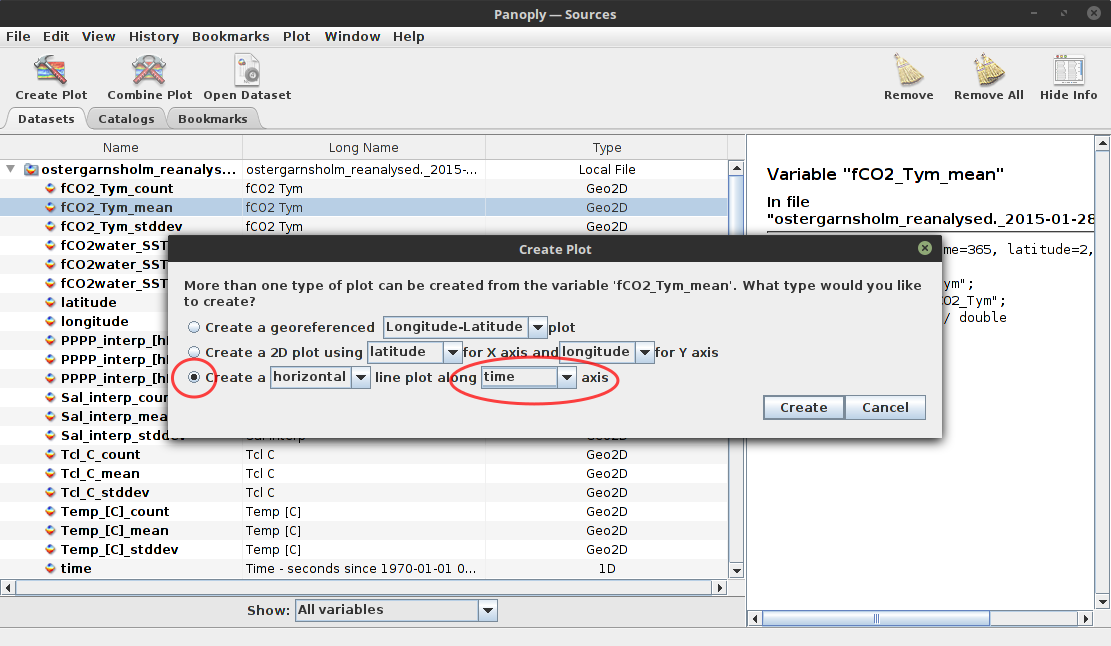

## Constructing the configuration file
Now we need to make the configuration file. This needs to differ from previous configuration files because we need to configure FluxEngine to do the following:
- Use the netCDF file we just created for each of the required input data fields
- Write output into a single file (to allow for easier visualisation as a time series)
- Perform the flux calculation using daily time steps

Despite this, a lot of the settings we have used previously will be the same, so it will save a lot of typing and reduce the scope for errors if we use another configuration file as a template, and modify it rather than starting from scratch. We will make a copy of the verification run configuration file and store it in out working directory in a file called `ostergarnsholm_reanalysed.conf`. You can do this by copying and renaming the file using your file browser, but for convenience you can just run the code below:

In [ ]:
import os.path as path
import shutil
from fluxengine.core.fe_setup_tools import get_fluxengine_root; #Gets filepath to fluxengine root directory

copyFrom = path.join(get_fluxengine_root(), "configs", "socatv4_sst_salinity_gradients-N00.conf");
copyTo = path.join(os.getcwd(), "ostergarnsholm_reanalysed.conf");
shutil.copy(copyFrom, copyTo);
print("Configuration file copied to:", copyTo);

### Specify the inputs
Open `ostergarnsholm_reanalysed.conf` with a plain text editor (i.e. not Microsoft Word) so that we can begin editing it. The first step is to substitute our input data file path and product names into each of the inputs (towards the end of the configuration file). Make sure each of the data layer input paths point to our new netCDF file (`output/reanalysed/ostergarnsholm/ostergarnsholm_reanalysed_2015-01-28_00-00-00.nc`). Set each of the product names to the corresponding variable in the netCDF file as specified below (these are the variable names you see if you open the file in Panoply):
- Sea surface temperature product name: `Tcl_C_mean`
- Wind speed product name(s): `windspeed_mean`, `wind_moment2_mean`, `wind_moment3_mean`
- Air pressure product name: `PPPP interp [hPa]_mean`
- Salinity product name: `Sal interp_mean`
- vCO<sub>2</sub> (atmospheric) product name: `xCO2air_interp_[umol_per_mol]_mean`
- pCO<sub>2</sub> (aqueous) product name: `fCO2_Tym_mean`

Take care to use the correct upper/lower case and combination of underscores and spaces in the product names.

Remove the two lines that define the ice input - we don't need them for the flux calculation - they are used in the verification run for calculating net intregrated global flux. You can also remove the lines specifying the `pco2_sst` input - this is for supplying SST measurements taken in conjunction with CO<sub>2</sub> data and can be used to apply a correction to the CO<sub>2</sub> data. We're not using it here, so remove them.

The temperature data we have from Östergarnsholm station is not skin temperature, but sub-skin. We need to update our configuration file to take this into account. First, at the top there are two settings that tell FluxEngine which type of temperature data to expect: `use_sstskin` (skin temperature) and `use_sstfnd` (foundation layer temperature). We'll use the foundation layer input, so change these so that they read `use_sstskin = no` and `use_sstfnd = yes`. Next change the definition of the `sstskin` input data layer so that it is instead specifying `sstfnd`, e.g.:
```
sstfnd_path = output/reanalysed/ostergarnsholm/ostergarnsholm_reanalysed_2015-01-28_00-00-00.nc
sstfnd_prod = Tcl_C_mean
```

Now, we should remove all the `dataLayerName_preprocessing` lines. These can be used to tell FluxEngine to apply preprocessing to inputs before the flux calculation is performed and are useful for things like unit conversion. Wee're using different input data from the verification run so we'll need different preprocessing functions. As it turns out, the only thing we need to do is convert our SST data from Celsius to Kelvin, so delete all the preprocessing functions from the configuration file, and then add the following line beneath the `sstfnd` input specification:
```
sstfnd_preprocessing = celsius_to_kelvin
```

By default FluxEngine is set up to expect separate input files for each time point and will therefore read the first temporal position of any input file. In our case this would mean it would repeatedly read and calculate fluxes using the first time point instead of using the full time series. To change this behaviour we need to tell FluxEngine how many time points are in each data file. This is the same idea as the temporal chunking option we used in the `text2ncdf.py` tool above. We can specify this for each input data layer using `dataLayerName_temporalChunking = 365`. This may seem laborious, but we have to do this for every input data layer because we could have different files with different temporal dimensions for each input field. Add a 'temporalChunking' line for each input; for example, the input specification for salinity should look like this
```
salinity_path = output/reanalysed/ostergarnsholm/ostergarnsholm_reanalysed_2015-01-28_00-00-00.nc
salinity_prod = Sal_interp_mean
salinity_temporalChunking = 365
```

### Specify the outputs
Now let's configure the output settings. Scroll up to where the output directory is set, `output_dir`, and change it to `output/fe_output/`. Override the default output directory structure by adding another line `output_structure =` (note that there it is purposefully blank after the `=` symbol - this prevents FluxEngine creating additional subdirectories). By default FluxEngine will create a separate file for each time step, but we want the whole year's worth of data in a single output file. To do this we can again use the temporal chunking setting, this time with the output. Add the following as a new line `output_temporal_chunking = 365`. Instead of using the default filename we should choose a name that conveys more information about what the file contains. Do this by setting `output_file = ostergarnsholm_reanalysed_fe_output.nc`.


### Setting the dimensions correctly
FluxEngine needs to be able to find the correct dimensions of your data. Near the top of the configuration file there is a setting called `axes_data_layer`. This specifies the data layer that will be used to extract dimension information for the whole calculation (FluxEngine requires that the spatial dimensions are the same for every input). Since we're using the same netCDF file for all of our input data layers, it doesn't matter which data layer we specify here. However, it is currently set to `sstskin`, which we don't supply as one of our inputs. Change this to use the `sstfnd` data layer instead; `axes_data_layer = sstfnd`.

Below this line are three options that define the product names for our latitude, longitude and time dimensions. These must match the respective product names for the variables in the selected netCDF file. If you have our netCDF file open in Panoply, you'll see that the temporal dimension is indeed called `time`, but the latitude and longitude dimensions are called `latitude` and `longitude`, as opposed to `lat` and `lon` as currently specified in the configuration file. Change these to read `latitude` and `longitude`. Once you're done it should look like this:
```
axes_data_layer = sstfnd
latitude_prod = latitude
longitude_prod = longitude
time_prod = time
```

Finally, we just need to tell FluxEngine what temporal resolution we want to perform the flux calculation for. We can do this by using the `temporal_resolution` setting. This takes a time interval of the format `days hh:mm`, so to specify a daily flux calculation we should set `temporal_resolution = 1 00:00`.

Leave the other values as they are for now. If you get stuck, there's a completed version of the configuration file here with the tutorial files where you installed FluxEngine: `tutorials/03_fixed_station_data/_completed/ostergarnsholm_reanalysed_completed.conf`. Remember you can look up more information configuration options in section 7.2 of the [manual](https://github.com/oceanflux-ghg/FluxEngine/blob/master/FluxEngineV4_instructions.pdf).

## Running FluxEngine
We have created a netCDF file containing all of our input data, and we've written a configuration file. The next step is to run these through FluxEngine to calculate the sea-to-air CO<sub>2</sub> fluxes. As before we'll use the command line tool to do this, `fe_ofluxghg_run.py`. Running this command will calculate the sea-to-air gas flux for each (daily) time step and you'll see FluxEngine output its progress for each day in the 10 month period. Thankfully, we're only calculating it for one point on the grid so it shouldn't take too long.

In [ ]:
!fe_run.py "ostergarnsholm_reanalysed.conf" -s "2015-01-28" -e "2015-11-26" -l

Once it's finished running, check to see that the output file is there (`output/tutorial_03_ostergarnsholm/ostergarnsholm_reanalysed_fe_output.nc`). Open it with Panoply and double click on the flux variable (`OF`) and plot it by selecting 'create a horizontal line plot along the time axis' to check it has run as expected.

## Running FluxEngine again without the reanalysis step
We could perform a quick analysis to see what effect the reanalysis step has on the calculated fluxes. We already have the input data in the correct format, so we just need to make a small modification to our configuration file to use the original fCO<sub>2</sub> and temperature data instead of the reanalysed versions. First, let's copy the configuration file we just ran and make some changes:

In [ ]:
import os.path as path;
import shutil;

copyFrom = path.join("ostergarnsholm_reanalysed.conf");
copyTo = path.join("ostergarnsholm_original.conf");
shutil.copy(copyFrom, copyTo);
print("Configuration file copied to:", copyTo);

Open the copied configuration file which is located in your working directory and named `ostergarnsholm_original.conf`.

First change the output file name, otherwise when we run it we'll overwrite our reanalysed data. Modify the output file specification to read `output_file = ostergarnsholm_original_fe_output.nc`.

Now we just need to modify the product name for fCO<sub>2</sub> and temperature inputs so that they point to the original data. Find these in the configuration file and change them to look like this:
```
sstfnd_prod = Temp [C]_mean

pgas_sw_prod = fCO2water_SST_wet [uatm]_mean
```

Now run FluxEngine again, this time using the modified configuration file:

In [ ]:
!fe_run.py "ostergarnsholm_original.conf" -s "2015-01-28" -e "2015-11-26" -l

You may want to open the new output file in Panoply and check everything has run as expected.

## Visualising the results
Now we have the original fixed station measurements and two output files from FluxEngine. It would be useful to be able to visualise these the fluxes together with the in situ measurements (and other inputs) that were used to calculate them.

We could use `fe_append2insitu.py` to merge the data, as we have done before. However, FluxEngine includes a copy of the data that were used to perform its flux calculations in the output files, and since we specifically formatted the output data to produce a time series we may as well plot the data directly using the FluxEngine output files! The downside of this is that we will be plotting the data with a lower temporal resolution (daily mean values, because we ran FluxEngine with a daily temporal resolution rather than the 30 minute measurements in the original data). For our purposes, we just want to get a general picture of the data so it doesn't matter much. If the higher temporal resolution was important we could use `fe_append2insitu.py` to merge your files by running commands like this for the original and reanalysed outputs:

In [ ]:
!fe_append2insitu.py "output/fe_output/ostergarnsholm_reanalysed_fe_output.nc" "output/reanalysed/ostergarnsholm/ostergarnsholm_reanalysed.tsv" "output/ostergarnsholm_reanalysed_merged.tsv" --varsToAppend "OF" "OK3" --dateIndex 1 --lonCol "Longitude" --latCol "Latitude"
!fe_append2insitu.py "output/fe_output/ostergarnsholm_original_fe_output.nc" "output/reanalysed/ostergarnsholm/ostergarnsholm_reanalysed.tsv" "output/ostergarnsholm_original_merged.tsv" --varsToAppend "OF" "OK3" --dateIndex 1 --lonCol "Longitude" --latCol "Latitude"

To visualise the FluxEngine output we'll use the `matplotlib` library in Python, but as before you could use any visualisation software or library you like (including R, Matlab and Microsoft Excel). You don't need to follow the Python code here. The script below just reads the two netCDF files produced by FluxEngine (reanalysed and original) then plots time series of in situ SST (black), Reynolds SST (blue), wind speed, molar fraction of CO<sub>2</sub> in dry air, in situ (black) and reanalysed (red) fCO<sub>2</sub>, and in situ (black) and reanalysed (red) sea-to-air CO<sub>2</sub> flux.

In [ ]:
from netCDF4 import Dataset
import matplotlib.pyplot as plt;

#Read the FluxEngine output files
ncOriginal = Dataset("output/fe_output/ostergarnsholm_original_fe_output.nc", 'r')
ncReanalysed = Dataset("output/fe_output/ostergarnsholm_reanalysed_fe_output.nc", 'r')

#Position of the station in the small grid
yIndex = 0
xIndex = 1

#Plot settings
ticksize = 16
alpha = 0.85
pad = 10; #padding between y axis and labels
rot = 90; #y label rotation

#Create the figure
f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, sharex=True, sharey=False, figsize=[10,12.5])
plt.xlabel("time (days since 28th Jan 2015)", fontsize=ticksize)
plt.tick_params(labelsize=ticksize)
time = range(0, 246);

#extract and plot SST data
insituSST = ncOriginal.variables["ST1_mean"][0:len(time), yIndex, xIndex]
reanalysedSST = ncReanalysed.variables["ST1_mean"][0:len(time), yIndex, xIndex]
ax1.plot(time, insituSST, 'k', linewidth=2, alpha=alpha, label="satellite")
ax1.plot(time, reanalysedSST, 'b', linewidth=2, alpha=alpha, label="in situ")
ax1.set_ylabel("SST\n($^{\circ}C$)", labelpad=pad, rotation=rot, fontsize=ticksize, horizontalalignment='center')
ax1.tick_params(labelsize=ticksize)


#plot wind speed
ax2.plot(time, ncOriginal.variables["WS1_mean"][0:len(time), yIndex, xIndex], 'b', linewidth=2, alpha=alpha); #windspeed [m s-1]
ax2.set_ylabel("wind speed\n($ms^{-1}$)", labelpad=pad, rotation=rot, fontsize=ticksize, horizontalalignment='center');
ax2.tick_params(labelsize=ticksize);

#plot xCO2 (air)
ax3.plot(time, ncOriginal.variables["OAPC1"][0:len(time), yIndex, xIndex], 'b', linewidth=2, alpha=alpha); #xCO2air_interp [umol/mol]
ax3.set_ylabel("xCO$_{2}$\n($\mu mol/mol$)", labelpad=pad, rotation=rot, fontsize=ticksize, horizontalalignment='center');
ax3.tick_params(labelsize=ticksize);

#Extract and plot fCO2 (aqueous)
reOBPC = ncReanalysed.variables["OBPC"][:];
OBPC = ncOriginal.variables["OBPC"][:];
ax4.plot(time, reOBPC[0:len(time), yIndex, xIndex], 'r', linewidth=2, alpha=alpha, label="reanalysed"); #fCO2water_SST_wet [uatm]
ax4.plot(time, OBPC[0:len(time), yIndex, xIndex], 'k', linewidth=2, alpha=alpha, label="in situ"); #fCO2water_SST_wet [uatm]
ax4.set_ylabel("$fCO_{2}$\n($\mu atm$)", labelpad=pad, rotation=rot, fontsize=ticksize, horizontalalignment='center');
ax4.tick_params(labelsize=ticksize);

#Extract and plot fluxes
ax5.plot(time, ncReanalysed.variables["OF"][0:len(time), yIndex, xIndex], 'r', linewidth=2, alpha=alpha, label="reanalysed"); #CO2 flux
ax5.plot(time, ncOriginal.variables["OF"][0:len(time), yIndex, xIndex], 'k', linewidth=2, alpha=alpha, label="in situ"); #CO2 flux
ax5.set_ylabel("$CO_{2}$ flux\n($gCm^{-2}day^{-1}$)", labelpad=pad, rotation=rot, fontsize=ticksize, horizontalalignment='center');
ax5.set_yticks([0.0, 0.5, 1.0]) 
ax5.tick_params(labelsize=ticksize);

plt.tight_layout();
plt.subplots_adjust(hspace = 0.1);
plt.show()

Notice how there are differences in fCO<sub>2</sub> between the measured and reanalysed data of up to 100 microatm in some places. In this case it doesn't translate into a particularly large difference in gas flux because it coincides with a period of low wind speed (and therefore the net gas flux is close to zero at that time anyway). You can see from the top plot (SST) that we used mean monthly SST to perform the reanalysis. This was just to avoid packaging the large volume of data with the FluxEngine download that would be required if we were to use a higher resolution (e.g. daily) dataset.

# Next steps
This concludes this tutorial. There is one more tutorial that demonstrates how to calculate fluxes of other (non-CO<sub>2</sub>) gases, using N<sub>2</sub>O data from the [MEMENTO](https://memento.geomar.de/home) database. You can access the tutorial by [clicking here](../04_N2O_fluxes/04_n2o_fluxes.ipynb).